In [1]:
import datetime
import requests
import io
import pandas as pd
import holidays

import matplotlib.pyplot as plt
%matplotlib inline 

# Functions

In [2]:
def select_time(df, start_time_hour=6, end_time_hour=13):
    df['HOUR'] = pd.to_datetime(df['TIME']).dt.hour
    df_time_frame = df[df["HOUR"].isin(list(range(start_time_hour, end_time_hour + 1)))]
    
    assert len(
        df_time_frame["HOUR"]
        .value_counts()
        .index
        .isin(list(range(start_time_hour, end_time_hour + 1)))
    ) == (end_time_hour + 1 ) - (start_time_hour)
    
    return df_time_frame


def get_daily_entry_counts(row, max_counter):
    counter = row["ENTRIES"] - row["LAST_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["ENTRIES"], row["LAST_ENTRIES"])
        counter = min(row["ENTRIES"], row["LAST_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter


def get_daily_exit_counts(row, max_counter):
    counter = row["EXITS"] - row["LAST_EXITS"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["EXITS"], row["LAST_EXITS"])
        counter = min(row["EXITS"], row["LAST_EXITS"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

# Get Data

In [ ]:
len(range(0,13))

In [7]:
##### SET START DATE | http://web.mta.info/developers/turnstile.html
date_val = datetime.date(2018, 9, 1)

dfs = []

##### SET RANGE for number of weeks of data needed
for x in range(14):
    
    url = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt'
    date_val_str = date_val.strftime("%y%m%d") # convert datetime format to string
    
    # create url from pieces above
    full_url = url.format(date_val_str)
    
    # Get data from url
    r = requests.get(full_url)
    r.raise_for_status()
    
    # Create dataframe
    r_content = r.content
    df_mta_data = pd.read_csv(io.StringIO(r_content.decode('utf-8')))
    dfs.append(df_mta_data)
    
    # Keep header if it's the first one, otherwise remove header and append to csv directly
    #if x == 0:
    #    df_mta_data.to_csv(output_file_loc, index = False, header = True)
            
    #else:
    #    with open(output_file_loc, 'a') as f:
    #        df_mta_data.to_csv(output_file_loc, mode = 'a', header = False, index = False)

    # Add 7 days to the date         
    date_val = date_val + datetime.timedelta(days = 7)
    
    # Just to make sure it's running smoothly
    print("Done with: " + full_url)
    print(x)
    
df = pd.concat(dfs)
print("yass done done done!!")    

Done with: http://web.mta.info/developers/data/nyct/turnstile/turnstile_180901.txt
0
Done with: http://web.mta.info/developers/data/nyct/turnstile/turnstile_180908.txt
1
Done with: http://web.mta.info/developers/data/nyct/turnstile/turnstile_180915.txt
2
Done with: http://web.mta.info/developers/data/nyct/turnstile/turnstile_180922.txt
3
Done with: http://web.mta.info/developers/data/nyct/turnstile/turnstile_180929.txt
4
Done with: http://web.mta.info/developers/data/nyct/turnstile/turnstile_181006.txt
5
Done with: http://web.mta.info/developers/data/nyct/turnstile/turnstile_181013.txt
6
Done with: http://web.mta.info/developers/data/nyct/turnstile/turnstile_181020.txt
7
Done with: http://web.mta.info/developers/data/nyct/turnstile/turnstile_181027.txt
8
Done with: http://web.mta.info/developers/data/nyct/turnstile/turnstile_181103.txt
9
Done with: http://web.mta.info/developers/data/nyct/turnstile/turnstile_181110.txt
10
Done with: http://web.mta.info/developers/data/nyct/turnstile/tu

# Clean Data

In [8]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/25/2018,00:00:00,REGULAR,6736067,2283184
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/25/2018,04:00:00,REGULAR,6736087,2283188
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/25/2018,08:00:00,REGULAR,6736105,2283229
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/25/2018,12:00:00,REGULAR,6736180,2283314
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/25/2018,16:00:00,REGULAR,6736349,2283384


In [9]:
len(df)

2784728

In [16]:
date_mask = ((pd.to_datetime(df['DATE']) > pd.datetime(2018, 8, 31)) & (pd.to_datetime(df['DATE']) < pd.datetime(2018, 12, 1)))

df = df[date_mask]

In [17]:
#clean up the columns
df.columns = [col.strip() for col in df.columns]

In [18]:
#Clean up the columns
df.columns = [col.strip() for col in df.columns]

#Add datetime column
df['DATE_TIME'] = df['DATE'] + " " + df['TIME']
df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'])

#Add Day of Week
df['DAY_OF_WEEK'] = (df['DATE_TIME']
                     .dt.dayofweek.map({0: "Monday", 
                                        1: "Tuesday", 
                                        2: "Wednesday", 
                                        3: "Thursday", 
                                        4: "Friday", 
                                        5: "Saturday", 
                                        6:"Sunday"}))

#Add Month
df['MONTH'] = (pd.DatetimeIndex(df['DATE_TIME'])
               .month.map({1:'January', 
                        2: 'February',
                        3: 'March',
                        4: 'April',
                        5: 'May',
                        6: 'June',
                        7: 'July', 
                        8: 'August', 
                        9: 'Septemner', 
                        10: 'October', 
                        11: 'November', 
                        12: 'December'}))

#Add Year
df['YEAR'] = pd.DatetimeIndex(df['DATE_TIME']).year

#Add Holiday
us_holidays = holidays.UnitedStates(years = [2018, 2019])
df['HOLIDAY'] = pd.to_datetime(df['DATE']).isin(us_holidays)

In [20]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,DAY_OF_WEEK,MONTH,YEAR,HOLIDAY
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/01/2018,00:00:00,REGULAR,6743736,2285840,2018-09-01 00:00:00,Saturday,Septemner,2018,False
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/01/2018,04:00:00,REGULAR,6743756,2285844,2018-09-01 04:00:00,Saturday,Septemner,2018,False
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/01/2018,08:00:00,REGULAR,6743769,2285873,2018-09-01 08:00:00,Saturday,Septemner,2018,False
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/01/2018,12:00:00,REGULAR,6743855,2285946,2018-09-01 12:00:00,Saturday,Septemner,2018,False
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/01/2018,16:00:00,REGULAR,6744069,2286006,2018-09-01 16:00:00,Saturday,Septemner,2018,False


In [21]:
#Get rid of duplicates
df = df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])

In [22]:
#Sanity check that dupes are removed
(df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(5)

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
0,A002,R051,02-00-00,59 ST,2018-09-01 00:00:00,1
1724733,R142,R293,01-00-02,34 ST-PENN STA,2018-09-02 10:00:00,1
1724726,R142,R293,01-00-02,34 ST-PENN STA,2018-09-01 06:00:00,1
1724727,R142,R293,01-00-02,34 ST-PENN STA,2018-09-01 10:00:00,1
1724728,R142,R293,01-00-02,34 ST-PENN STA,2018-09-01 14:00:00,1


# Filter Data & Sum Entries

In [28]:
df_morn.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,DAY_OF_WEEK,MONTH,YEAR,HOLIDAY,HOUR
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/01/2018,08:00:00,REGULAR,6743769,2285873,2018-09-01 08:00:00,Saturday,Septemner,2018,False,8
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/01/2018,12:00:00,REGULAR,6743855,2285946,2018-09-01 12:00:00,Saturday,Septemner,2018,False,12
8,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/02/2018,08:00:00,REGULAR,6744471,2286100,2018-09-02 08:00:00,Sunday,Septemner,2018,False,8
9,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/02/2018,12:00:00,REGULAR,6744555,2286148,2018-09-02 12:00:00,Sunday,Septemner,2018,False,12
14,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/03/2018,08:00:00,REGULAR,6745007,2286291,2018-09-03 08:00:00,Monday,Septemner,2018,True,8


In [ ]:
# df_morn containing only morning data for each turnstile
df_morn = select_time(df)

# sort values
df_morn.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"],inplace=True, ascending=True)
   

In [33]:
# dataframe containing earliest turnstile log for each day
df_first = (df_morn
            .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
            .head(1))

# dataframe containing latest turnstile log for each day
df_last = (df_morn
           .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
           .tail(1)[["C/A", "UNIT", "SCP", "STATION", "DATE", 'ENTRIES', 'EXITS', 'TIME']]).rename(columns={'ENTRIES': 'LAST_ENTRIES', 'EXITS': 'LAST_EXITS', 'TIME': 'LAST_TIME'})

In [34]:
df_last.head()

,C/A,UNIT,SCP,STATION,DATE,LAST_ENTRIES,LAST_EXITS,LAST_TIME
3,A002,R051,02-00-00,59 ST,09/01/2018,6743855,2285946,12:00:00
9,A002,R051,02-00-00,59 ST,09/02/2018,6744555,2286148,12:00:00
15,A002,R051,02-00-00,59 ST,09/03/2018,6745091,2286368,12:00:00
21,A002,R051,02-00-00,59 ST,09/04/2018,6745768,2286801,12:00:00
27,A002,R051,02-00-00,59 ST,09/05/2018,6747060,2287385,12:00:00


In [35]:
# merge
df_daily = pd.merge(df_first, df_last, on = ["C/A", "UNIT", "SCP", "STATION","DATE"], how = 'left')

In [36]:
df_daily.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,DAY_OF_WEEK,MONTH,YEAR,HOLIDAY,HOUR,LAST_ENTRIES,LAST_EXITS,LAST_TIME
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/01/2018,08:00:00,REGULAR,6743769,2285873,2018-09-01 08:00:00,Saturday,Septemner,2018,False,8,6743855,2285946,12:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/02/2018,08:00:00,REGULAR,6744471,2286100,2018-09-02 08:00:00,Sunday,Septemner,2018,False,8,6744555,2286148,12:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/03/2018,08:00:00,REGULAR,6745007,2286291,2018-09-03 08:00:00,Monday,Septemner,2018,True,8,6745091,2286368,12:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/04/2018,08:00:00,REGULAR,6745607,2286584,2018-09-04 08:00:00,Tuesday,Septemner,2018,False,8,6745768,2286801,12:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/05/2018,08:00:00,REGULAR,6746909,2287150,2018-09-05 08:00:00,Wednesday,Septemner,2018,False,8,6747060,2287385,12:00:00


In [37]:
# Calculate Daily Entries per Turnstile
df_daily["DAILY_ENTRIES"] = df_daily.apply(get_daily_entry_counts, axis=1, max_counter=1000000)

# Calculate Daily Exits per Turnstile
df_daily["DAILY_EXITS"] = df_daily.apply(get_daily_exit_counts, axis=1, max_counter=1000000)

# Calculate Total Entries & Exits per Turnstile
df_daily['DAILY_TOTAL'] = df_daily['DAILY_ENTRIES'] + df_daily['DAILY_EXITS']


2318009 242
3346426 524317
119257511 458918
706535159 137
13162 5599832
1511819 69
1106847 6165
6396 1111172
6765 1114279
7220 1117287
7681 1120326
7901 1121621
8057 1122563
1123198 8396
1125487 8817
9458 1133804
1136327 9970
10054 1138236
10188 1139937
10340 1143293
10802 1146455
11289 1149464
11841 1152619
12600 1153938
12790 1155525
12980 1157352
13475 1160284
13985 1163420
14425 1166637
14872 1169858
1170688 15074
1172522 15270
1174238 15673
2794719 4
2857784 0
15767 98488484
9594918 23444
1502539 27907
1569166011 27598
14025188 147
5497831 30146
4978691 35
33683103 18
38520 9797208
4758 1005918
4960 1008574
5376 1011047
5448 1012817
5509 1013225
5714 1015886
5949 1018319
6159 1021076
6450 1023662
1026001 6557
1027815 6618
1029122 6680
1475467 2
1941630 1050
1138814 889
14792 1155567663
2014116 6100305
4665167 26963
1129054900 13683
4710100 192826


In [38]:
# Create column to identify Station
df_daily['UNIQUE_STATION'] = df_daily['STATION'] + " " + df_daily['LINENAME']

In [39]:
df_daily.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,...,YEAR,HOLIDAY,HOUR,LAST_ENTRIES,LAST_EXITS,LAST_TIME,DAILY_ENTRIES,DAILY_EXITS,DAILY_TOTAL,UNIQUE_STATION
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/01/2018,08:00:00,REGULAR,6743769,...,2018,False,8,6743855,2285946,12:00:00,86,73,159,59 ST NQR456W
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/02/2018,08:00:00,REGULAR,6744471,...,2018,False,8,6744555,2286148,12:00:00,84,48,132,59 ST NQR456W
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/03/2018,08:00:00,REGULAR,6745007,...,2018,True,8,6745091,2286368,12:00:00,84,77,161,59 ST NQR456W
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/04/2018,08:00:00,REGULAR,6745607,...,2018,False,8,6745768,2286801,12:00:00,161,217,378,59 ST NQR456W
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/05/2018,08:00:00,REGULAR,6746909,...,2018,False,8,6747060,2287385,12:00:00,151,235,386,59 ST NQR456W


In [40]:
# Clean up df_daily
cols = ['C/A', 
        'UNIT', 
        'SCP', 
        'STATION',
        'LINENAME',
        'UNIQUE_STATION',
        'DATE',
        'TIME',
        'DESC',
        'DAY_OF_WEEK', 
        'MONTH', 
        'YEAR', 
        'HOLIDAY', 
        'ENTRIES', 
        'EXITS', 
        'LAST_ENTRIES', 
        'LAST_EXITS',
        'LAST_TIME', 
        'DAILY_ENTRIES', 
        'DAILY_EXITS', 
        'DAILY_TOTAL']

df_daily_clean = df_daily[cols]
df_daily_clean.head()

,C/A,UNIT,SCP,STATION,LINENAME,UNIQUE_STATION,DATE,TIME,DESC,DAY_OF_WEEK,...,YEAR,HOLIDAY,ENTRIES,EXITS,LAST_ENTRIES,LAST_EXITS,LAST_TIME,DAILY_ENTRIES,DAILY_EXITS,DAILY_TOTAL
0,A002,R051,02-00-00,59 ST,NQR456W,59 ST NQR456W,09/01/2018,08:00:00,REGULAR,Saturday,...,2018,False,6743769,2285873,6743855,2285946,12:00:00,86,73,159
1,A002,R051,02-00-00,59 ST,NQR456W,59 ST NQR456W,09/02/2018,08:00:00,REGULAR,Sunday,...,2018,False,6744471,2286100,6744555,2286148,12:00:00,84,48,132
2,A002,R051,02-00-00,59 ST,NQR456W,59 ST NQR456W,09/03/2018,08:00:00,REGULAR,Monday,...,2018,True,6745007,2286291,6745091,2286368,12:00:00,84,77,161
3,A002,R051,02-00-00,59 ST,NQR456W,59 ST NQR456W,09/04/2018,08:00:00,REGULAR,Tuesday,...,2018,False,6745607,2286584,6745768,2286801,12:00:00,161,217,378
4,A002,R051,02-00-00,59 ST,NQR456W,59 ST NQR456W,09/05/2018,08:00:00,REGULAR,Wednesday,...,2018,False,6746909,2287150,6747060,2287385,12:00:00,151,235,386


# EDA

Still working...

In [54]:
len(df_daily_clean)

427848

In [61]:
df_daily_clean[['DAILY_TOTAL', 'STATION']][df_daily_clean['DAILY_TOTAL'] < 6000]
#.sort_values(by = 'DAILY_TOTAL', ascending = False)

,DAILY_TOTAL,STATION
0,159,59 ST
1,132,59 ST
2,161,59 ST
3,378,59 ST
4,386,59 ST
...,...,...
427843,0,RIT-ROOSEVELT
427844,0,RIT-ROOSEVELT
427845,0,RIT-ROOSEVELT
427846,0,RIT-ROOSEVELT


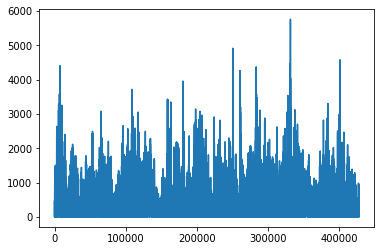

In [62]:
plt.plot(df_daily_clean['DAILY_TOTAL'][df_daily_clean['DAILY_TOTAL'] < 6000])

In [72]:
df_daily_clean[df_daily_clean['DAILY_TOTAL'] == 0]

,C/A,UNIT,SCP,STATION,LINENAME,UNIQUE_STATION,DATE,TIME,DESC,DAY_OF_WEEK,...,YEAR,HOLIDAY,ENTRIES,EXITS,LAST_ENTRIES,LAST_EXITS,LAST_TIME,DAILY_ENTRIES,DAILY_EXITS,DAILY_TOTAL
74,A002,R051,02-00-00,59 ST,NQR456W,59 ST NQR456W,11/14/2018,07:00:00,REGULAR,Wednesday,...,2018,False,6834427,2317507,6834427,2317507,07:00:00,0,0,0
163,A002,R051,02-00-01,59 ST,NQR456W,59 ST NQR456W,11/14/2018,07:00:00,REGULAR,Wednesday,...,2018,False,6106607,1368481,6106607,1368481,07:00:00,0,0,0
252,A002,R051,02-03-00,59 ST,NQR456W,59 ST NQR456W,11/14/2018,07:00:00,REGULAR,Wednesday,...,2018,False,1153650,4323527,1153650,4323527,07:00:00,0,0,0
341,A002,R051,02-03-01,59 ST,NQR456W,59 ST NQR456W,11/14/2018,07:00:00,REGULAR,Wednesday,...,2018,False,897955,1395803,897955,1395803,07:00:00,0,0,0
430,A002,R051,02-03-02,59 ST,NQR456W,59 ST NQR456W,11/14/2018,07:00:00,REGULAR,Wednesday,...,2018,False,5982254,8107107,5982254,8107107,07:00:00,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427843,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT-ROOSEVELT R,11/26/2018,08:00:00,REGULAR,Monday,...,2018,False,5554,366,5554,366,12:00:00,0,0,0
427844,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT-ROOSEVELT R,11/27/2018,08:00:00,REGULAR,Tuesday,...,2018,False,5554,366,5554,366,12:00:00,0,0,0
427845,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT-ROOSEVELT R,11/28/2018,08:00:00,REGULAR,Wednesday,...,2018,False,5554,366,5554,366,12:00:00,0,0,0
427846,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT-ROOSEVELT R,11/29/2018,08:00:00,REGULAR,Thursday,...,2018,False,5554,366,5554,366,12:00:00,0,0,0


In [73]:
total_mask = ((df_daily_clean['DAILY_TOTAL'] < 6000) & (df_daily_clean['DAILY_TOTAL'] != 0))

In [77]:
df_daily_clean[total_mask].groupby("UNIQUE_STATION")["DAILY_TOTAL"].sum().sort_values(ascending = False)[:20]

UNIQUE_STATION
GRD CNTRL-42 ST 4567S           5605365
34 ST-HERALD SQ BDFMNQRW        4481824
34 ST-PENN STA ACE              3225225
42 ST-PORT AUTH ACENQRS1237W    3002208
47-50 STS ROCK BDFM             2720976
FULTON ST 2345ACJZ              2442809
TIMES SQ-42 ST 1237ACENQRSW     2304804
14 ST-UNION SQ LNQR456W         2304192
PATH NEW WTC 1                  2180284
59 ST COLUMBUS ABCD1            2074798
FLUSHING-MAIN 7                 2035862
LEXINGTON AV/53 EM6             1997549
34 ST-PENN STA 123ACE           1860886
59 ST 456NQRW                   1724754
86 ST 456                       1684785
JKSN HT-ROOSVLT EFMR7           1680137
42 ST-BRYANT PK BDFM7           1623134
CANAL ST JNQRZ6W                1518492
72 ST 123                       1423057
34 ST-PENN STA 123              1330278
Name: DAILY_TOTAL, dtype: int64

In [81]:
df_daily_clean[["UNIQUE_STATION", 'DAILY_TOTAL']][total_mask]

,UNIQUE_STATION,DAILY_TOTAL
0,59 ST NQR456W,159
1,59 ST NQR456W,132
2,59 ST NQR456W,161
3,59 ST NQR456W,378
4,59 ST NQR456W,386


In [110]:
top_5_stations = list(df_daily_clean[total_mask]
 .groupby("UNIQUE_STATION")["DAILY_TOTAL"]
 .sum()
 .sort_values(ascending = False)[5:10].index)

In [111]:
top_5_mask = top_5_stations

In [98]:
df_daily_clean['UNIQUE_STATION'].isin(top_20_stations)

0         False
1         False
2         False
3         False
4         False
          ...  
427843    False
427844    False
427845    False
427846    False
427847    False
Name: UNIQUE_STATION, Length: 427848, dtype: bool

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


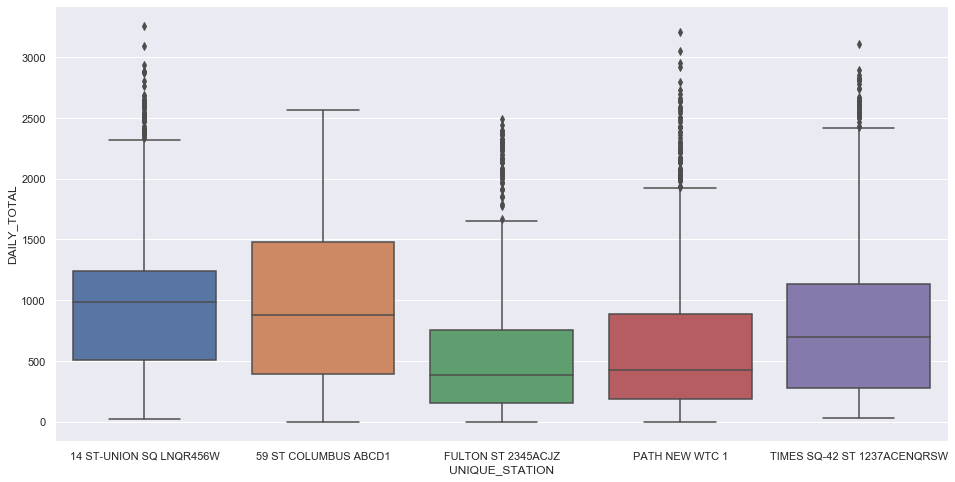

In [112]:
import seaborn as sns

sns.set()

from matplotlib import pyplot

fig, ax = pyplot.subplots(figsize = (16, 8))
sns.boxplot(x = "UNIQUE_STATION", y = "DAILY_TOTAL", data = df_daily_clean[total_mask][df_daily_clean['UNIQUE_STATION'].isin(top_5_stations)], ax = ax)
                               
#df_daily_clean[["UNIQUE_STATION", 'DAILY_TOTAL']][total_mask])

In [89]:
df_daily_clean[total_mask].sort_values(by = 'DAILY_TOTAL', ascending = False)[:20]['STATION'].unique()

array(['GRD CNTRL-42 ST', 'THIRTY ST', '34 ST-HUDSON YD'], dtype=object)

In [ ]:
pd.set_option('display.max_columns', 100)

In [ ]:
mask_filter = (df_daily_clean["DAILY_ENTRIES"] < 2500)
df_filter = df_daily_clean[mask_filter]

In [ ]:
# Some turnstiles have only one reading in the morning, and so don't have a reading..
df_filter[(df_filter['UNIQUE_STATION'] == '86 ST 1') & (df_filter['DAILY_TOTAL'] == 0)][['DATE','TIME', 'LAST_TIME']]

In [ ]:
df[((df['STATION'] == '86 ST') & (df['LINENAME'] == '1'))][['ENTRIES', 'EXITS', 'DATE', 'TIME']]

In [ ]:
#(df_daily_clean
# .groupby(['STATION', 'LINENAME', 'DATE'])
# .sum()['DAILY_ENTRIES', 'DAILY_EXITS', 'DAILY_TOTAL']
# .rename(columns = {'DAILY_ENTRIES': 'DAILY_STATION_ENTRIES', 
#                    'DAILY_EXITS': 'DAILY_STATION_EXITS', 
#                    'DAILY_TOTAL': 'DAILY_STATION_TOTAL'}))

(df_filter
 .groupby(['DAY_OF_WEEK', 'UNIQUE_STATION'])
 .mean()[['DAILY_TOTAL']]
 .sort_values(by = ['DAY_OF_WEEK'], ascending = False)).iloc[:30].reset_index()[df_filter['']]

In [ ]:
df_daily_clean[df_daily_clean['DESC'] == 'RECOVR AUD']

In [ ]:
len(df_daily)

In [ ]:
mask = (df_daily_clean["DAILY_ENTRIES"] < 2500)
df_daily_clean[mask]

In [ ]:
df_daily_clean[df_daily["DAILY_ENTRIES"] > 5000]

#mask = ((df_daily['STATION'] == 'JOURNAL SQUARE') & (df_daily['DATE'] == '08/29/2018'))
#df_daily[df_daily[mask]
         
#df_daily[mask].sort_values(by = 'TIME')
#df_daily[df_daily["DAILY_ENTRIES"] > 5000]

In [ ]:
mask = ((df_daily_clean['STATION'] == 'JOURNAL SQUARE') & (df_daily['DATE'] == '08/29/2018'))
#plt.plot(df_daily_clean['DAILY_ENTRIES'][mask])

#plt.plot(df_daily['DAILY_ENTRIES'][(df_daily['DAILY_ENTRIES'] < 5000) & (df)])

plt.plot(df_daily['DAILY_ENTRIES'][df_daily["DAILY_ENTRIES"] < 2500])

In [ ]:
df_daily["DAILY_EXITS"] = df_daily.apply(get_daily_exit_counts, axis=1, max_counter=1000000)

In [ ]:
plt.plot(df_daily['DAILY_EXITS'][df_daily['DAILY_EXITS'] < 3500])

In [ ]:
import numpy as np
stations_list = df_daily_clean['UNIQUE_STATION'].unique()
np.savetxt("/Users/JacKuo14/Documents/Metis/nyc19_ds21_foottraffic_team2/data/station_names.csv", stations_list, delimiter=",", fmt='%s')


# Analysis

Still working...

In [ ]:
#df_daily.groupby(['STATION', 'LINENAME', 'DATE'])['DAILY_ENTRIES', 'DAILY_EXITS'].sum().reset_index()
df_daily.groupby(['DAY_OF_WEEK'])['DAILY_ENTRIES', 'DAILY_EXITS'].sum().reset_index().sort_values(by = 'DAILY_ENTRIES')